# Index-Tracking Portfolio Optimization

Index-Tracking investing is a passive investment strategy that attempts to generate returns similar to a broad market index.

**Full Replication**

A physical index replication where the fund holds the shares of all the assets in the index and needs to replicate as close as possible each asset’s weight in the index. Trading illiquid assets in the index could add to higher costs to the fund, resulting in higher expense ratios and impacting the fund's performance.

**Portfolio Optimization**

The aim is replicate the index using an optimal portfolio selection of the larger assets in the index by reducing Tracking Error.

**Tracking Error**

In the contexts of indices,

Tracking Error = Standard Deviation of (P - I)

The standard deviation of the difference between the returns of a portfolio and the index.


Information Ratio (Similar to Sharpe) = (Portfolio Return - Index Return) / Tracking Error
CFA Institute's Performance Evaluation https://www.cfainstitute.org/-/media/documents/support/programs/investment-foundations/19-performance-evaluation.ashx?la=en&hash=F7FF3085AAFADE241B73403142AAE0BB1250B311

**Russell 1000**
is a stock market index maintained by FTSE Russell that tracks the highest-ranking 1,000 stocks in the entire U.S stock market that we aim to replicate

**Test Period:** 2019-04-01 to 2019-04-30

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Index-Tracking-Portfolio-Optimization" data-toc-modified-id="Index-Tracking-Portfolio-Optimization-0">Index-Tracking Portfolio Optimization</a></span></li><li><span><a href="#1.-Packages" data-toc-modified-id="1.-Packages-1">1. Packages</a></span></li><li><span><a href="#2.-Data-Collection" data-toc-modified-id="2.-Data-Collection-2">2. Data Collection</a></span></li><li><span><a href="#3.-Benchmark-Index-Reconstruction-based-on-Russell-Methodology" data-toc-modified-id="3.-Benchmark-Index-Reconstruction-based-on-Russell-Methodology-3">3. Benchmark Index Reconstruction based on Russell Methodology</a></span></li><li><span><a href="#4.-Allocation-with-Non-negative-Least-Squares-(NNLS)-Optimization" data-toc-modified-id="4.-Allocation-with-Non-negative-Least-Squares-(NNLS)-Optimization-4">4. Allocation with Non-negative Least Squares (NNLS) Optimization</a></span><ul class="toc-item"><li><span><a href="#4.1-Using-data-since-the-latest-reconstitution" data-toc-modified-id="4.1-Using-data-since-the-latest-reconstitution-4.1">4.1 Using data since the latest reconstitution</a></span></li><li><span><a href="#4.2-Using-data-before-the-latest-reconstitution" data-toc-modified-id="4.2-Using-data-before-the-latest-reconstitution-4.2">4.2 Using data before the latest reconstitution</a></span></li><li><span><a href="#4.3-Testing-hypothesis-that-the-error-is-due-to-relying-on-the-wrong-components" data-toc-modified-id="4.3-Testing-hypothesis-that-the-error-is-due-to-relying-on-the-wrong-components-4.3">4.3 Testing hypothesis that the error is due to relying on the wrong components</a></span></li></ul></li><li><span><a href="#5.-Allocation-with-relative-Partial-Correlation" data-toc-modified-id="5.-Allocation-with-relative-Partial-Correlation-5">5. Allocation with relative Partial Correlation</a></span></li><li><span><a href="#6.-Allocation-with-Dynamic-Time-Warping-(DTW)-Optimization" data-toc-modified-id="6.-Allocation-with-Dynamic-Time-Warping-(DTW)-Optimization-6">6. Allocation with Dynamic Time Warping (DTW) Optimization</a></span></li><li><span><a href="#7.-Allocation-with-Non-negative-Matrix-Factorization-(NMF)" data-toc-modified-id="7.-Allocation-with-Non-negative-Matrix-Factorization-(NMF)-7">7. Allocation with Non-negative Matrix Factorization (NMF)</a></span></li><li><span><a href="#8.-Allocation-with-Particle-Swarm-Optimisation-(PSO)" data-toc-modified-id="8.-Allocation-with-Particle-Swarm-Optimisation-(PSO)-8">8. Allocation with Particle Swarm Optimisation (PSO)</a></span></li></ul></div>

# 1. Packages

In [1]:
# <-- Click In[66] to see code
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import pyswarms as ps
from scipy.optimize import nnls
from datetime import date
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
from sklearn.decomposition import NMF
from tslearn.metrics import dtw
from pyswarms.utils.search.grid_search import GridSearch
from pyswarms.utils.search.random_search import RandomSearch
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

c:\Users\wdrdg\anaconda3\envs\fairness\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# 2. Data Collection

According to the FTSE Russell annual reconstitution schedules, there is a 'rank day' where the rankings for the top 1000 companies by market cap are computed at market close. Subsequently, there is a transition period before the reconstitution takes place on the 'effect day' where markets open with the newly reconstituted index. We should be careful to account for this in approximating the index with the top companies because they (or their weights) might change across the years.

https://www.ftserussell.com/press/ftse-russell-announces-schedule-annual-russell-us-index-reconstitution
https://www.ftserussell.com/press/ftse-russell-announces-2018-russell-us-indexes-reconstitution-schedule

I was unable to find free public data of the top 25 constituents of Russell 1000 at every reconstitution. It was unavailable on YahooFinance, my retail broker TDAmeritrade, FTSE's page, Quandl, and google searches on different key words. The following alternatives I've found include:

- Using FTSE's published weights as of 2019-12-31 - goes beyond the test data period and would likely be inaccurate.
https://www.ftse.com/ANALYTICS/FACTSHEETS/HOME/DownloadConstituentsWeights/?indexdetails=US1000


- Using the largest ETF (by AUM) tracking the index to obtain component weights - data as of 2019-12-31. https://www.ishares.com/us/products/239707/ishares-russell-1000-etf/1467271812596.ajax?fileType=csv&fileName=IWB_holdings&dataType=fund


- Chosen option: Using the Top 10 components of the index published by FTSE's reconstitution recap report in 2018 and 2017. While limited to only 10, the allocation is correct at least.
https://content.ftserussell.com/sites/default/files/support_document/2017_russell_reconstitution_recap_final.pdf
https://content.ftserussell.com/sites/default/files/support_document/2018-russell-us-index-reconstitution-recap_0.pdf

**Dates**

In [67]:
# <--
rank_day20 = "2020-05-08"
effect_day20 = "2020-06-29"
rank_day21 = "2021-05-07"
effect_day21_minus1 = "2021-06-27"
effect_day21 = "2021-06-28"
train_end = "2022-02-28"
val_start = "2022-03-01" # validate on a 1-month-before hold-out set
val_end = "2022-03-31"
test_start = "2022-04-01"
test_end = "2022-04-30"

**Top 10 components and their weights**

Obtained from

https://content.ftserussell.com/sites/default/files/russell_us_indexes_recon_2020_recap_6.26.2020.pdf

https://content.ftserussell.com/sites/default/files/2021_russell_us_indexes_reconstitution_recap.pdf

In [68]:
# <--
top10of20_cap = {'MSFT':1400.5,'AAPL':1344.2,'AMZN':1186.9,'GOOG':945,'META':605,'BRK-A':429.7,'V':394.1,'JNJ':391.8,'WMT':348.4,'PG':139.91}
top10of21_cap = {'AAPL':2172.9,'MSFT':1901.4,'AMZN':1660,'GOOG':1576.2,'META':904.7,'BRK-A':664.4,'TSLA':647.7,'V':492.9,'JPM':488.1,'JNJ':433.7}

**Calculate no. of shares available**

According to the Russell Index Calculation Methodology, the Total Return index calculation requires knowledge of the dividend ex-dates and dividend/special dividend per share. Since we are limited by data, we will use the Price Return index calculation instead.

https://research.ftserussell.com/products/downloads/Russell_Index_Calculation_Methodology.pdf?_ga=2.110735813.1991880057.1587129456-1914712361.1587129456

Without taking into account corporate action for each stock, I made the assumption that the no. of shares available changes only at the reconstitution dates. The no. of shares will not be exact as the market cap provided by FTSE above is rounded.

In [69]:
data = yf.download("AAPL", start="2017-05-02", end="2017-05-03", threads=True)

[*********************100%***********************]  1 of 1 completed


In [70]:
# <--
# Store no. of shares for each component
top10of20_shares = {}
top10of21_shares = {}

components20_query = " ".join(list(top10of20_cap.keys()))
components21_query = " ".join(list(top10of21_cap.keys()))

rank_day20_data = yf.download(tickers = components20_query,
                   start=rank_day20,
                   end="2020-05-09",
                   interval="1d",group_by="ticker",auto_adjust=True,prepost=False,threads=True);

rank_day21_data = yf.download(tickers = components21_query,
                   start=rank_day21,
                   end="2021-05-08",
                   interval="1d",group_by="ticker",auto_adjust=True,prepost=False,threads=True);

for component in top10of20_cap.keys():
    top10of20_shares[component] = math.ceil(top10of20_cap[component] * 10**9 / rank_day20_data[component]['Close'])

for component in top10of21_cap.keys():
    top10of21_shares[component] = math.ceil(top10of21_cap[component] * 10**9 / rank_day21_data[component]['Close'])
    
print("\nMarket Cap of Top 10 in 2020", top10of20_shares)
print("\nMarket Cap of Top 10 in 2021", top10of21_shares)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed

Market Cap of Top 10 in 2020 {'MSFT': 7798612086, 'AAPL': 17634211056, 'AMZN': 9975584296, 'GOOG': 13613085299, 'META': 2849069850, 'BRK-A': 1619798, 'V': 2172912123, 'JNJ': 2849881813, 'WMT': 2946978810, 'PG': 1290831635}

Market Cap of Top 10 in 2021 {'AAPL': 16859890965, 'MSFT': 7667325150, 'AMZN': 10086249257, 'GOOG': 13142173256, 'META': 2835339220, 'BRK-A': 1519911, 'TSLA': 2889926633, 'V': 2153548997, 'JPM': 3182970516, 'JNJ': 2710657831}


**Collect Index and Component Close**

In [71]:
# <--
# Index
RUI = yf.download(tickers = "^RUI",
                   start=effect_day20,
                   end=test_end,
                   interval="1d",group_by="column",auto_adjust=True,prepost=False,threads=True)
# Components
components20 = yf.download(tickers=components20_query,
                   start=effect_day20,
                   end=effect_day21_minus1,
                   interval="1d",group_by="column",auto_adjust=True,prepost=False,threads=True)['Close']

components21 = yf.download(tickers=components21_query,
                   start=effect_day21,
                   end=test_end,
                   interval="1d",group_by="column",auto_adjust=True,prepost=False,threads=True)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [72]:
RUI

,Open,High,Low,Close,Volume
Date,,,,,
2020-06-29,1668.540039,1691.380005,1661.209961,1690.979980,0
2020-06-30,1690.900024,1723.250000,1688.599976,1717.469971,0
2020-07-01,1719.599976,1733.599976,1718.510010,1726.719971,0
2020-07-02,1729.660034,1754.849976,1729.660034,1735.010010,0
2020-07-06,1736.469971,1765.050049,1736.469971,1762.890015,0
...,...,...,...,...,...
2022-04-25,2351.000000,2370.399902,2317.360107,2369.300049,0
2022-04-26,2358.139893,2358.139893,2301.209961,2301.409912,0
2022-04-27,2309.770020,2335.389893,2294.080078,2305.280029,0


# 3. Benchmark Index Reconstruction based on Russell Methodology

As mentioned above, we will use the Price Return Index calculation from

https://research.ftserussell.com/products/downloads/Russell_Index_Calculation_Methodology.pdf?_ga=2.110735813.1991880057.1587129456-1914712361.1587129456 page 4

The Russell Index value is obtained by compounding the daily return percentages of the Price Return Index. The starting value of the index is equal to the base and this was set as 100 on 12/31/78. Therefore on our base date: 2020-06-29, we will use the ^RUI's Close = 1690.97 (from Yahoo Finance) as our base value

https://research.ftserussell.com/products/downloads/Russell-US-equity-indexes-IOSCO.pdf?_ga=2.110735813.1991880057.1587129456-1914712361.1587129456 page 34

In [73]:
# <--
components20.head(3)

,AAPL,AMZN,BRK-A,GOOG,JNJ,META,MSFT,PG,V,WMT
Date,,,,,,,,,,
2020-06-29,88.921875,134.018997,265219.0,69.748497,129.439377,220.639999,193.500916,109.985970,187.847061,114.491638
2020-06-30,89.664177,137.940994,267300.0,70.680496,130.919601,227.070007,198.444733,111.771370,189.604004,115.184006
2020-07-01,89.494568,143.934998,267020.0,71.902000,130.686890,237.550003,199.605087,112.154648,190.202774,115.097458


**Calculation based on Russell Methodology**

In [74]:
# <--
market_value20 = pd.DataFrame({'Market Value':np.zeros(len(components20.index))}, index=components20.index)
market_value21 = pd.DataFrame({'Market Value':np.zeros(len(components21.index))}, index=components21.index)
for component in top10of20_cap.keys():
    market_value20['Market Value'] =  market_value20['Market Value'] + components20[component] * top10of20_shares[component]
for component in top10of21_cap.keys():
    market_value21['Market Value'] = market_value21['Market Value'] + components21[component] * top10of21_shares[component]
benchmark = pd.concat([market_value20,market_value21])
benchmark['EMV/BMV'] = benchmark['Market Value'] / benchmark['Market Value'].shift(1)
# not rolling but just use price return = emv/bmv - 1 as the first IV only
current_IV = benchmark['Market Value'].pct_change()[1]
IVs = [np.nan, current_IV]
# updating and adding IVs for each subsequent day
for ratio in benchmark['EMV/BMV'][2:]:
    IVs.append(current_IV*ratio)
    current_IV *= ratio
benchmark['IV'] = IVs 
benchmark['Return'] = benchmark['IV'].pct_change() * 100
benchmark['Daily Compounded Return'] = benchmark['Return'].cumsum()
benchmark['Benchmark Close'] = benchmark['Daily Compounded Return'] + 1341.03
benchmark = benchmark.dropna()
benchmark.head()

,Market Value,EMV/BMV,IV,Return,Daily Compounded Return,Benchmark Close
Date,,,,,,
2020-07-01,7.928466e+12,1.014428,0.018170,1.442770,1.442770,1342.472770
2020-07-02,7.958677e+12,1.003810,0.018239,0.381038,1.823808,1342.853808
2020-07-06,8.178784e+12,1.027656,0.018744,2.765626,4.589434,1345.619434
2020-07-07,8.132938e+12,0.994395,0.018639,-0.560541,4.028894,1345.058894
2020-07-08,8.257775e+12,1.015350,0.018925,1.534951,5.563844,1346.593844


**Overall evaluation of benchmark against actual index**

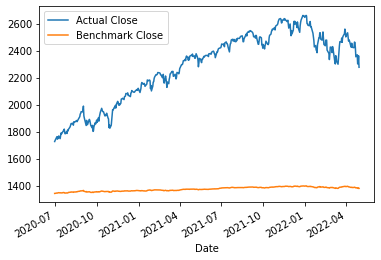

In [75]:
# <--
benchmark.dropna(inplace=True)
benchmark_close = benchmark['Benchmark Close']
RUI['Actual Close'] = RUI['Close']
index_close = RUI[(benchmark.index[0] <= RUI.index) & (RUI.index <= benchmark.index[-1])]['Actual Close']
closes = pd.concat([index_close,benchmark_close], axis=1)
closes.plot();

**Evaluation of benchmark in test period**

In [76]:
# <--
test = closes[(closes.index >= "2022-04-01") & (closes.index <= "2022-04-30")]

def evaluate(df,portfolio_col,is_test):
    df2 = pd.DataFrame({
        'Actual Daily Return':df['Actual Close'].pct_change()
    })
    
    index_hpr = (df['Actual Close'][-1] - df['Actual Close'][0]) / df['Actual Close'][0]
    
    if is_test:
        benchmark_hpr = (df['Benchmark Close'][-1] - df['Benchmark Close'][0]) / df['Benchmark Close'][0]
        benchmark_active_return = benchmark_hpr - index_hpr
        benchmark_return = df['Benchmark Close'].pct_change().dropna()
        actual_return = df['Actual Close'].pct_change().dropna()
        benchmark_tracking_error = np.std(benchmark_return - actual_return)
        info_ratio = benchmark_active_return / benchmark_tracking_error
        df2['Benchmark Daily Return'] = df['Benchmark Close'].pct_change()
        print("Benchmark")
        print("*"*30)
        print("Active Return:", round(benchmark_active_return,5))
        print("Tracking Error:", round(benchmark_tracking_error*10000), " bps")
        print("Information Ratio:", round(info_ratio,5))
        print("Price RMSE:", mean_squared_error(df['Benchmark Close'],df['Actual Close'],squared=False))
        df2['Benchmark Daily Return'] = df['Benchmark Close'].pct_change()
        df2.dropna(inplace=True)
        print("Returns RMSE:", mean_squared_error(df2['Benchmark Daily Return'],df2['Actual Daily Return'],squared=False))
    
    if portfolio_col:
        portfolio_hpr = (df[portfolio_col][-1] - df[portfolio_col][0]) / df[portfolio_col][0]
        portfolio_active_return = portfolio_hpr - index_hpr
        
        portfolio_return = df[portfolio_col].pct_change().dropna()
        actual_return = df['Actual Close'].pct_change().dropna()
        portfolio_tracking_error = np.std(portfolio_return - actual_return)
        info_ratio = portfolio_active_return / portfolio_tracking_error
        print("\nCurrent Portfolio")
        print("*"*30)
        print("Active Return:", round(portfolio_active_return,5))
        print("Tracking Error:", round(portfolio_tracking_error*10000), " bps")
        print("Information Ratio:", round(info_ratio,5))
        print("Price RMSE:", mean_squared_error(df[portfolio_col],df['Actual Close'],squared=False))  
        colname = portfolio_col[:-6]+" Daily Return"
        df2[colname] = df[portfolio_col].pct_change()
        df2.dropna(inplace=True)
        print("Returns RMSE:", mean_squared_error(df2[colname],df2['Actual Daily Return'],squared=False))
        
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
    df.plot(ax=axs[0])
    df2.plot(ax=axs[1])
    

# 4. Allocation with Non-negative Least Squares (NNLS) Optimization

The idea is to fit a linear combination of the current top 10 components against index prices in a constrained linear least squares model for the training period.

The coeffs obtained will then be non-negative. Each coeff is taken over the sum of coeffs as weightings for each component to be taken in the test period.

The sum of weightings will be the amount of leverage that the portfolio requires to replicate the index price.

The method is simple and intuitive, the goal is to find:
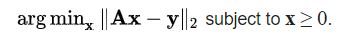

the algorithm used below is obtained from  Lawson, Charles L.; Hanson, Richard J. (1995). Solving Least Squares Problems. SIAM.

## 4.1 Using data since the latest reconstitution 
If we need to generate portfolio weightings for the month of April, we could use several months of training data since the last reconstitution date. However, if we needed to generate portfolio weightings right after the reconstitution, we might have to rely on prices from components which were not previously in the top 10 nor in the index.

**Prices as IVs**

In [77]:
# <--
# Train Val Test split
df = components21.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

df.head(3)

,AAPL,AMZN,BRK-A,GOOG,JNJ,JPM,META,MSFT,TSLA,V,Actual Close
Date,,,,,,,,,,,
2021-06-28,133.403122,172.194504,416304.0,126.819504,156.715775,146.775558,355.640015,264.568817,229.573334,231.155777,2419.439941
2021-06-29,134.937286,172.406998,417000.0,126.018501,156.725342,146.594879,351.890015,267.207428,226.919998,232.992462,2420.010010
2021-06-30,135.560867,172.007996,418601.0,125.316002,157.403717,147.926331,347.709991,266.715179,226.566666,230.889145,2421.139893


**Portfolio Allocation**

NNLS Residual 169.85975

Portfolio Allocation:


,Component,Weight(%)
0,JNJ,23.440626
1,GOOG,17.780272
2,AMZN,15.610187
3,JPM,15.451188
4,MSFT,12.433238
5,V,6.599966
6,TSLA,3.940411
7,META,3.206972
8,AAPL,1.531520
9,BRK-A,0.005620



Portfolio Simulated Close = 
11.78701(0.01532*AAPL + 0.1561*AMZN + 6e-05*BRK-A + 0.1778*GOOG + 0.23441*JNJ + 0.15451*JPM + 0.03207*META + 0.12433*MSFT + 0.0394*TSLA + 0.066*V)

Leverage Factor: 11.78700845430112


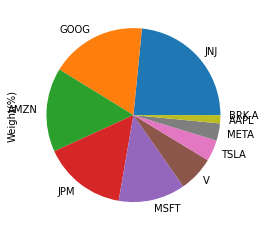

In [78]:
# <--
# Obtain coeffs from NNLS training
def get_portfolio_allocation(trainX, trainY):
    result = nnls(trainX, trainY)
    print('NNLS Residual', round(result[1],5))
    
    leverage_factor = sum(result[0])
    weights = result[0] / leverage_factor
    weights = dict(zip(trainX.columns, weights))
    
    s1 = str(round(leverage_factor,5))+"("
    for component in weights.keys():
        s1 += str(round(weights[component],5))+'*'+component+" + "
    s1 = s1[:-3]+")"
    
    print("\nPortfolio Allocation:")
    allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
    allocation.set_index('Component',inplace=True)
    allocation.plot.pie(y='Weight(%)',legend=None)
    allocation.reset_index(inplace=True)
    display(allocation)
    
    print('\nPortfolio Simulated Close = ')
    print(s1)
    print("\nLeverage Factor:", leverage_factor)
    return leverage_factor, weights

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

**Check for multicollinearity**

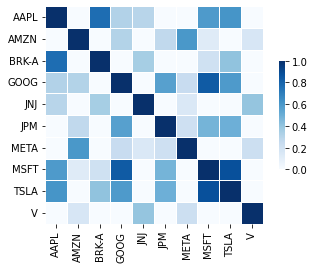

In [79]:
# <--
corr = trainX.corr()
sns.heatmap(corr,cmap="Blues",vmin=0,square=True,linewidths=.5,cbar_kws={"shrink": .5});

The coeffs estimate the effect of a single IV on the DV, holding other IVs constant. Since there is high multicollinearity, it causes imprecise estimates of coeffs, and the val and test coeffs will also be imprecise. This could lead to large errors in extrapolation.

**Validation Results**


Current Portfolio
******************************
Active Return: 0.02484
Tracking Error: 37  bps
Information Ratio: 6.67306
Price RMSE: 39.35556697585889
Returns RMSE: 0.003872159955246081


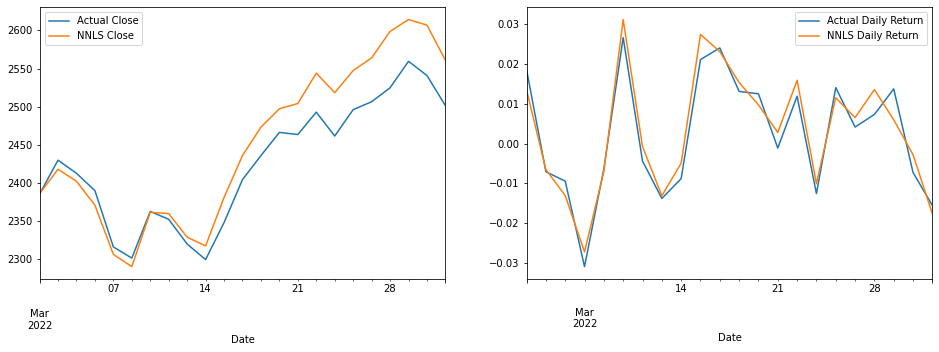

In [80]:
# <--
valY['NNLS Close'] = leverage_factor*valX.dot(list(weights.values()))
evaluate(valY,'NNLS Close',is_test=False)

**Test Results**

Benchmark
******************************
Active Return: 0.08371
Tracking Error: 140  bps
Information Ratio: 5.98929
Price RMSE: 1036.5755351630814
Returns RMSE: 0.014688811647052866

Current Portfolio
******************************
Active Return: -0.01431
Tracking Error: 42  bps
Information Ratio: -3.38646
Price RMSE: 37.610507771730184
Returns RMSE: 0.004302757693719623


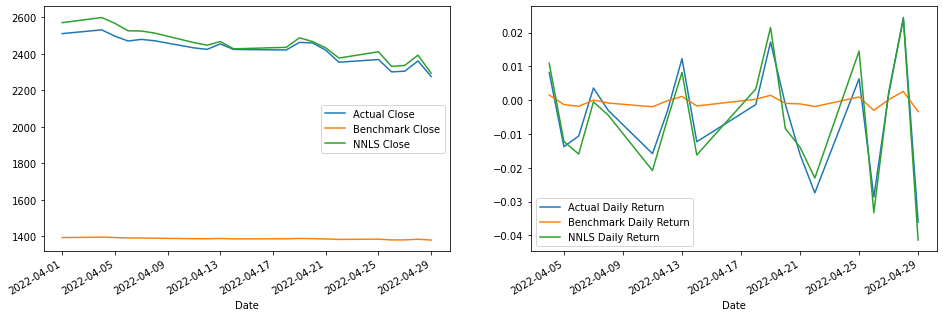

In [81]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'NNLS Close',is_test=True)

RMSE may be a better indicator than the Tracking Error because the benchmark barely changes and thus there is little variance which makes the tracking error naturally low. RMSE is also easier to detect visually.

It seems to match up the prices of the index very well with the simulated index.

## 4.2 Using data before the latest reconstitution
A more realistic scenario would be to train the model on data before the latest reconstitution date so that we could obtain weights to use right after the reconstitution. We might not have the privilege of having training data after the reconstitution.

The training set will then be the entire year's worth of data from the 2017 reconstitution to the 2018 reconstitution.

NNLS Residual 431.26808

Portfolio Allocation:


,Component,Weight(%)
0,GOOG,37.690402
1,JNJ,25.824536
2,AAPL,21.605784
3,WMT,10.447350
4,V,4.426490
5,BRK-A,0.005439
6,AMZN,0.000000
7,META,0.000000
8,MSFT,0.000000
9,PG,0.000000



Portfolio Simulated Close = 
14.72187(0.21606*AAPL + 0.0*AMZN + 5e-05*BRK-A + 0.3769*GOOG + 0.25825*JNJ + 0.0*META + 0.0*MSFT + 0.0*PG + 0.04426*V + 0.10447*WMT)

Leverage Factor: 14.721867399873357


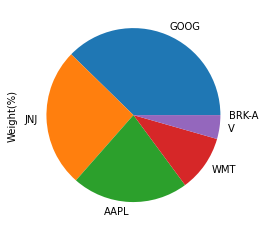

In [85]:
# <--
# Train Val Test split
df_before = components20.copy()
df_before.dropna(inplace=True)
df_before['Actual Close'] = RUI['Actual Close']

df_after = components21.copy()
df_after.dropna(inplace=True)
df_after['Actual Close'] = RUI['Actual Close']

train = df_before
val = df_after[(df_after.index >= val_start) & (df_after.index <= val_end)]
test = df_after[(df_after.index >= test_start) & (df_after.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

In [86]:
df_after

,AAPL,AMZN,BRK-A,GOOG,JNJ,JPM,META,MSFT,TSLA,V,Actual Close
Date,,,,,,,,,,,
2021-06-28,133.403122,172.194504,416304.0,126.819504,156.715775,146.775558,355.640015,264.568817,229.573334,231.155777,2419.439941
2021-06-29,134.937286,172.406998,417000.0,126.018501,156.725342,146.594879,351.890015,267.207428,226.919998,232.992462,2420.010010
2021-06-30,135.560867,172.007996,418601.0,125.316002,157.403717,147.926331,347.709991,266.715179,226.566666,230.889145,2421.139893
2021-07-01,135.867706,171.648499,421005.0,126.368500,158.569382,149.390945,354.390015,267.404327,225.973328,232.202484,2432.370117
2021-07-02,138.530212,175.548996,420000.0,128.718994,161.454895,149.247452,354.700012,273.360870,226.300003,235.638870,2448.870117
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,161.899277,146.074005,506200.0,123.250000,181.108810,123.630966,186.990005,277.992828,332.673340,208.304779,2369.300049
2022-04-26,155.855896,139.391006,497777.0,119.505997,179.813843,119.973816,180.949997,267.594818,292.140015,199.524139,2301.409912
2022-04-27,155.627274,138.167007,496800.0,115.020500,177.301834,118.413437,174.949997,280.468475,293.836670,212.432190,2305.280029


**Test Results**

Benchmark
******************************
Active Return: 0.08371
Tracking Error: 140  bps
Information Ratio: 5.98929
Price RMSE: 1036.5755351630814
Returns RMSE: 0.014688811647052866

Current Portfolio
******************************
Active Return: -0.00281
Tracking Error: 45  bps
Information Ratio: -0.6225
Price RMSE: 448.6196521572249
Returns RMSE: 0.004513337992088821


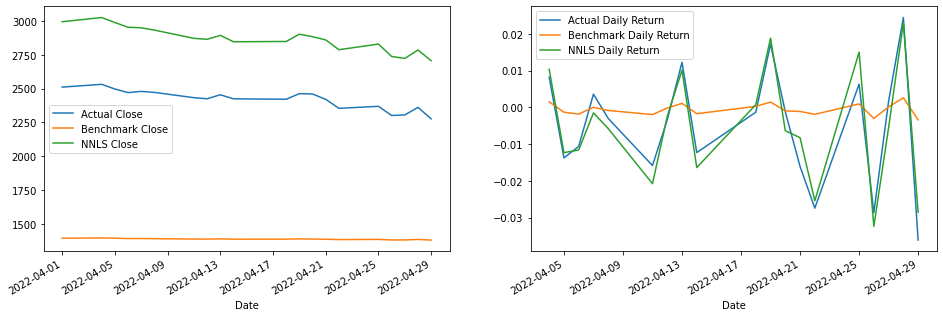

In [87]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'NNLS Close',is_test=True)

In [88]:
RUI

,Open,High,Low,Close,Volume,Actual Close
Date,,,,,,
2020-06-29,1668.540039,1691.380005,1661.209961,1690.979980,0,1690.979980
2020-06-30,1690.900024,1723.250000,1688.599976,1717.469971,0,1717.469971
2020-07-01,1719.599976,1733.599976,1718.510010,1726.719971,0,1726.719971
2020-07-02,1729.660034,1754.849976,1729.660034,1735.010010,0,1735.010010
2020-07-06,1736.469971,1765.050049,1736.469971,1762.890015,0,1762.890015
...,...,...,...,...,...,...
2022-04-25,2351.000000,2370.399902,2317.360107,2369.300049,0,2369.300049
2022-04-26,2358.139893,2358.139893,2301.209961,2301.409912,0,2301.409912
2022-04-27,2309.770020,2335.389893,2294.080078,2305.280029,0,2305.280029


As expected, the Tracking Error & RMSE is much higher since we have relied on prices from components which were not previously in the top 10 nor in the index (WFC was in the top 10 in 2017 but not in 2018).

## 4.3 Testing hypothesis that the error is due to relying on the wrong components
To prove the above hypothesis, I will validate/test on Mar/Apr 2018 rather than train on the 2017 components and validate/test on Mar/Apr 2019 so that it uses the right components for the year.

NNLS Residual 344.7003

Portfolio Allocation:


,Component,Weight(%)
0,GOOG,42.299709
1,JNJ,24.870904
2,AAPL,16.396748
3,WMT,14.380719
4,V,2.044384
5,BRK-A,0.007536
6,AMZN,0.000000
7,META,0.000000
8,MSFT,0.000000
9,PG,0.000000



Portfolio Simulated Close = 
14.29991(0.16397*AAPL + 0.0*AMZN + 8e-05*BRK-A + 0.423*GOOG + 0.24871*JNJ + 0.0*META + 0.0*MSFT + 0.0*PG + 0.02044*V + 0.14381*WMT)

Leverage Factor: 14.299911094244091


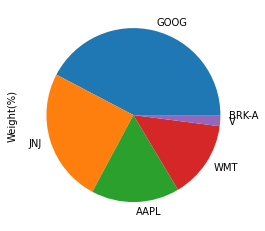

In [91]:
# <--
# Train Val Test split
df_before = components20.copy()
df_before.dropna(inplace=True)
df_before['Actual Close'] = RUI['Actual Close']

df_after = components21.copy()
df_after.dropna(inplace=True)
df_after['Actual Close'] = RUI['Actual Close']

train = df_before[(df_before.index < "2021-03-01")]
val = df_before[(df_before.index >= "2021-03-01") & (df_before.index <= "2021-03-31")]
test = df_before[(df_before.index >= "2021-04-01") & (df_before.index <= "2021-04-30")]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

leverage_factor, weights = get_portfolio_allocation(trainX, trainY)

**Test Results**

Benchmark
******************************
Active Return: -0.03467
Tracking Error: 58  bps
Information Ratio: -5.99474
Price RMSE: 962.3309475783216
Returns RMSE: 0.00603313760584889

Current Portfolio
******************************
Active Return: 0.02228
Tracking Error: 46  bps
Information Ratio: 4.79907
Price RMSE: 15.365360329099635
Returns RMSE: 0.004764284645949443


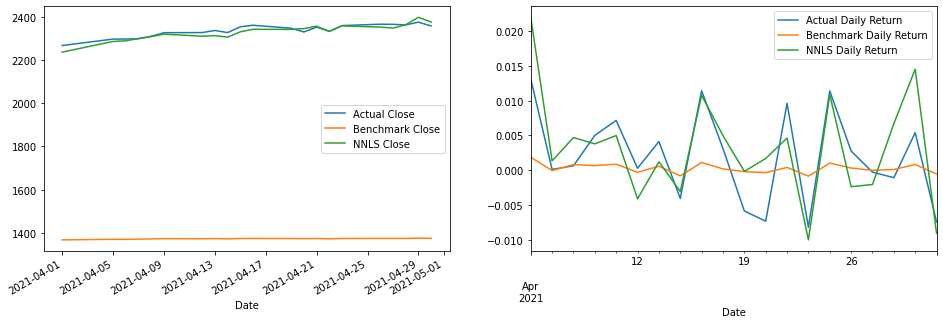

In [92]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NNLS Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'NNLS Close',is_test=True)

The results look a lot better and the Price RMSE reduced significantly. This supports my claim that we should only use the model on the right components for the year. This means we cannot use the model on the earlier months after a reconstitution but should wait until there is sufficient training samples for these components before execution.

# 5. Allocation with relative Partial Correlation
The idea is to allocate more weight to a component if it is more correlated with the index's actual close.

Partial correlation correlates the residuals from 1) least-squares regression of Index on the other IVs & 2) least-squares regression of individual IV on other IVs. This accounts for confounding & 3rd party effects.

**Using correlation without accounting for effects from other variables vs partial correlation**

In [93]:
# <--
# Train Val Test split
df = components21.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

correls = pd.DataFrame({'Correlation':train.corr()['Actual Close'], 'Partial Correlation':train.pcorr()['Actual Close']})
correls

,Correlation,Partial Correlation
AAPL,0.464930,0.131952
AMZN,0.342267,0.603080
BRK-A,0.111955,0.235182
GOOG,0.852029,0.373772
JNJ,0.067353,0.437781
JPM,0.594708,0.455355
META,0.248617,0.538631
MSFT,0.884126,0.381588
TSLA,0.752409,0.521341
V,-0.468447,0.325567


Ignore negatively correlated components by setting to 0, assuming a Long-only portfolio\
Take each correlation over the sum to get the weightings


**Portfolio Allocation**


Portfolio Allocation:


,Component,Weight(%)
0,AMZN,15.061014
1,META,13.451484
2,TSLA,13.019693
3,JPM,11.371791
4,JNJ,10.932901
5,MSFT,9.529574
6,GOOG,9.334398
7,V,8.130545
8,BRK-A,5.873303
9,AAPL,3.295298



Portfolio Simulated Close = 
4.00425(0.03295*AAPL + 0.15061*AMZN + 0.05873*BRK-A + 0.09334*GOOG + 0.10933*JNJ + 0.11372*JPM + 0.13451*META + 0.0953*MSFT + 0.1302*TSLA + 0.08131*V)

Leverage Factor: 4.004248545877224


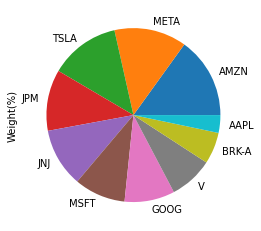

In [94]:
# <--
weights = correls['Partial Correlation'].apply(lambda x:max(0,x))[:-1]
leverage_factor = sum(weights)
weights = (weights / leverage_factor).to_dict()

s1 = str(round(leverage_factor,5))+"("
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]+")"

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)
print("\nLeverage Factor:", leverage_factor)

**Validation Results**


Current Portfolio
******************************
Active Return: 0.06276
Tracking Error: 142  bps
Information Ratio: 4.40604
Price RMSE: 117792.4833069969
Returns RMSE: 0.014482711401369518


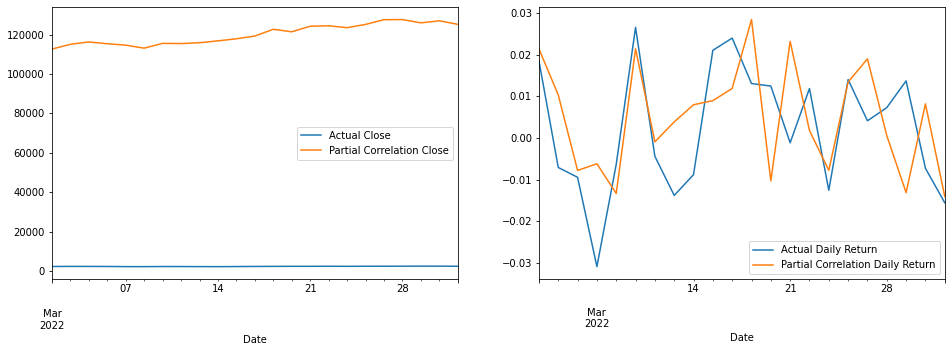

In [95]:
# <--
valY['Partial Correlation Close'] = leverage_factor*valX.dot(list(weights.values()))
evaluate(valY,'Partial Correlation Close',is_test=False)

**Test Results**

Benchmark
******************************
Active Return: 0.08371
Tracking Error: 140  bps
Information Ratio: 5.98929
Price RMSE: 1036.5755351630814
Returns RMSE: 0.014688811647052866

Current Portfolio
******************************
Active Return: 0.0109
Tracking Error: 120  bps
Information Ratio: 0.90963
Price RMSE: 119340.0156616603
Returns RMSE: 0.012001174739806914


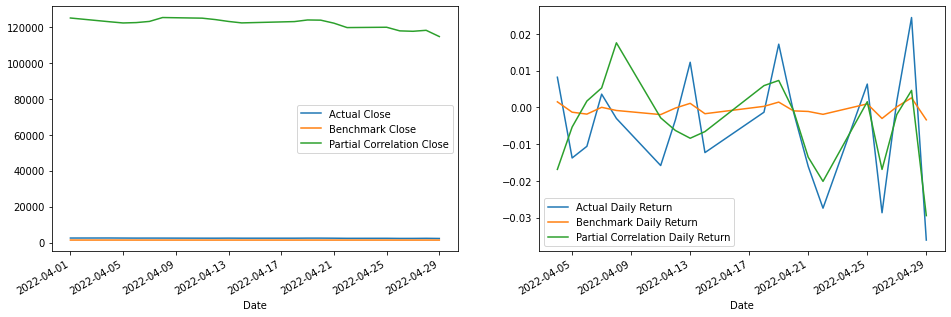

In [96]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['Partial Correlation Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'Partial Correlation Close',is_test=True)

Tracking Error and Returns RMSE are higher than the benchmark. However the Price RMSE is a lot lower.
This is probably due to the oversimplification made by this model in considering effects of each component independently.

# 6. Allocation with Dynamic Time Warping (DTW) Optimization

Pearson correlation is unable to capture shape similarity and will determine that a pair of timeseries are uncorrelated with each other even though they maybe be very similar and simply out of phase. This could be apparent between leading/lagging variables and their counterparts. DTW distance accounts for shape similarity.

The idea is to allocate more weight to a component if it has a relatively shorter DTW distance with the index and thus, a more similar shape.


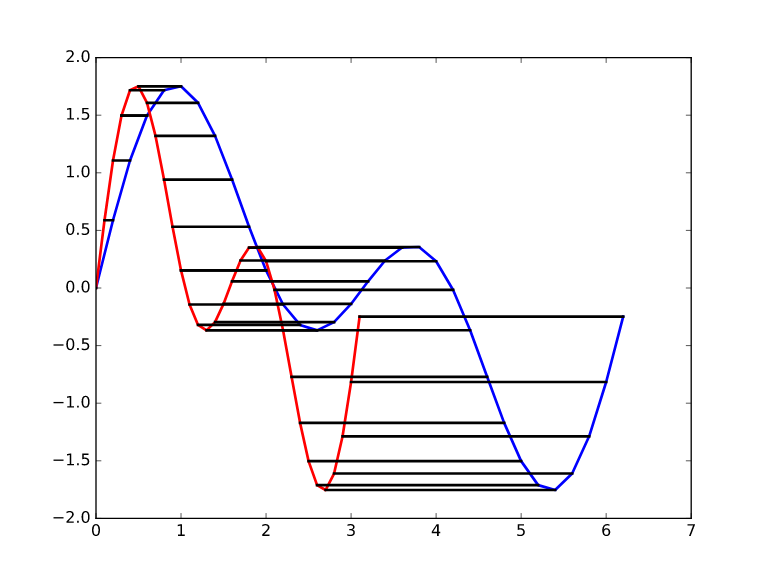

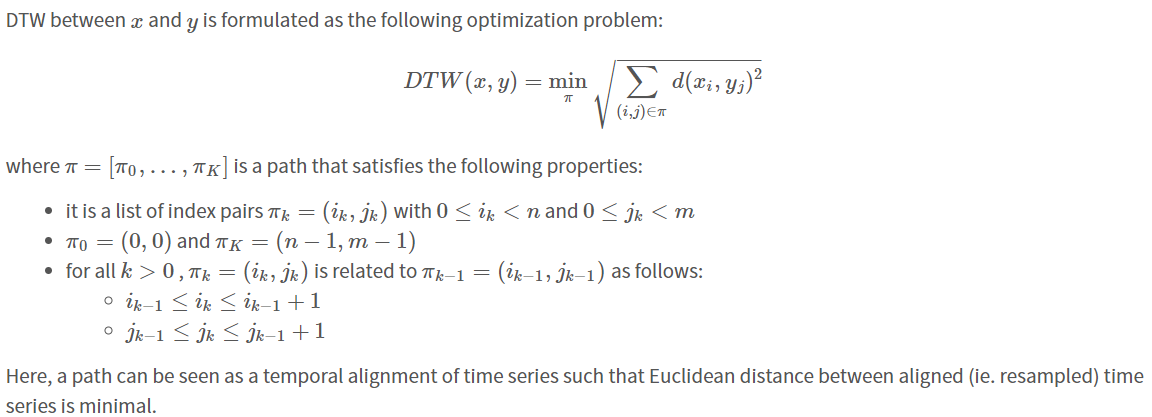

**Dynamic Time Warping Distances**

In [97]:
# <--
# Train Val Test split
df = components21.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

distances = trainX.apply(lambda x: dtw(x, trainY))
pd.DataFrame({'DTW Distance from Index':distances})

,DTW Distance from Index
AAPL,3.082069e+04
AMZN,3.065377e+04
BRK-A,5.677343e+06
GOOG,3.101881e+04
JNJ,3.074301e+04
JPM,3.085104e+04
META,2.854437e+04
MSFT,2.889984e+04
TSLA,2.903835e+04
V,2.996160e+04


**Portfolio Allocation**


Portfolio Allocation:


,Component,Weight(%)
0,META,11.682669
1,MSFT,11.538974
2,TSLA,11.483932
3,V,11.130061
4,AMZN,10.878742
5,JNJ,10.847163
6,AAPL,10.819824
7,JPM,10.809181
8,GOOG,10.750717
9,BRK-A,0.058738



Portfolio Simulated Close = 
0.1082*AAPL + 0.10879*AMZN + 0.00059*BRK-A + 0.10751*GOOG + 0.10847*JNJ + 0.10809*JPM + 0.11683*META + 0.11539*MSFT + 0.11484*TSLA + 0.1113*V


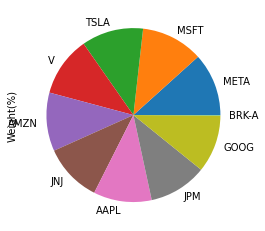

In [98]:
# <--
distances = 1 / distances
weights = (distances / sum(distances)).to_dict()

s1 = ""
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)

**Validation Results**


Current Portfolio
******************************
Active Return: 0.05483
Tracking Error: 72  bps
Information Ratio: 7.6634
Price RMSE: 1929.4509015871045
Returns RMSE: 0.0075145375630943055


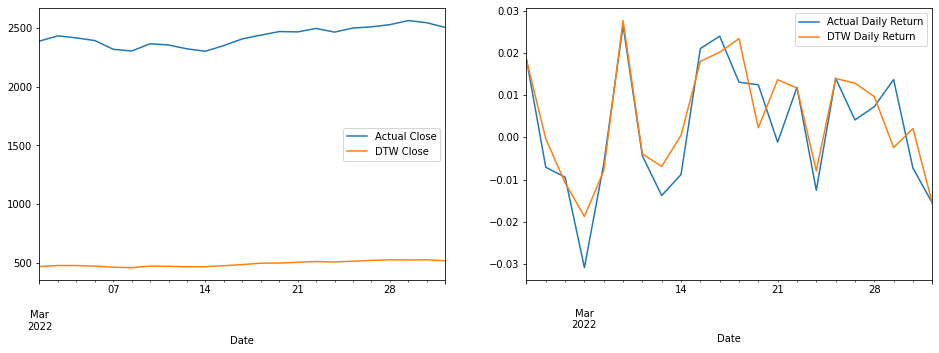

In [99]:
# <--
valY['DTW Close'] = valX.dot(list(weights.values()))
evaluate(valY,'DTW Close',is_test=False)

**Test Results**

Benchmark
******************************
Active Return: 0.08371
Tracking Error: 140  bps
Information Ratio: 5.98929
Price RMSE: 1036.5755351630814
Returns RMSE: 0.014688811647052866

Current Portfolio
******************************
Active Return: -0.0056
Tracking Error: 53  bps
Information Ratio: -1.04887
Price RMSE: 1920.0915840205857
Returns RMSE: 0.0053527286557869085


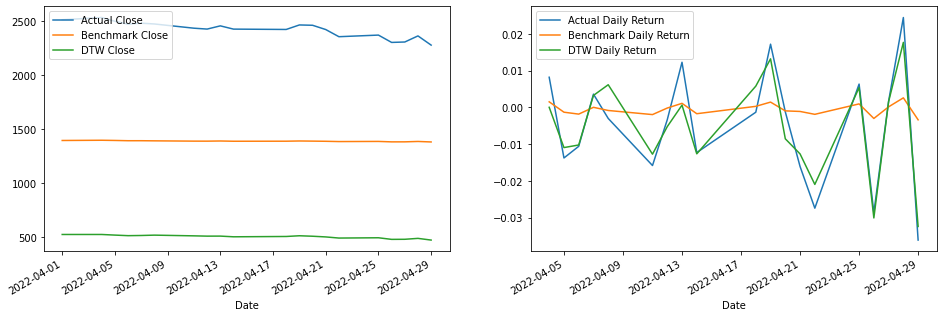

In [100]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['DTW Close'] = testX.dot(list(weights.values()))
evaluate(testY,'DTW Close',is_test=True)

Partial Correlation model - Tracking Error: 44  bps, Price RMSE: 86.72, Returns RMSE: 0.004944

The Tracking error, Price RMSE & Returns RMSE performed worse than the Partial Correlation Model. This could mean that the shape similarity might not have been a huge factor in differentiating each component from each other.

# 7. Allocation with Non-negative Matrix Factorization (NMF)
While NNLS is a supervised learning approach, the unsupervised NMF method is able to learn the representation of the data via a single principal component. The principal component will be a linear combination of the assets such that the coeffs will be non-negative due to the constraints in this algo. The algo decomposes the data into two matrices of non-negative elements by optimizing the distance between X and Y=WH. X is represented by linear combinations in W using coeffs in H.
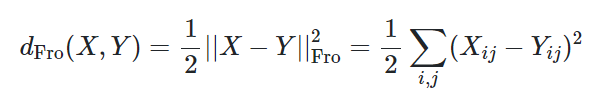
The idea is to find the relative importance of each asset in contributing to the overall variation in the data and use that as our weightings.

In [101]:
# <--
# Train Val Test split
df = components21.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

**Coeffs in Principal Component**


Portfolio Allocation:


c:\Users\wdrdg\anaconda3\envs\fairness\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


,Component,Weight(%)
0,BRK-A,99.563786
1,META,0.074596
2,MSFT,0.068637
3,TSLA,0.066385
4,V,0.050223
5,AMZN,0.038049
6,JNJ,0.036605
7,AAPL,0.035306
8,JPM,0.034670
9,GOOG,0.031743



Portfolio Simulated Close = 
0.00035*AAPL + 0.00038*AMZN + 0.99564*BRK-A + 0.00032*GOOG + 0.00037*JNJ + 0.00035*JPM + 0.00075*META + 0.00069*MSFT + 0.00066*TSLA + 0.0005*V


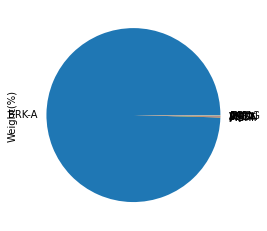

In [102]:
# <--
nmf = NMF(n_components=1)
nmf.fit(trainX)
coeffs = nmf.components_.tolist()[0]
leverage_factor = sum(coeffs)
weights = dict(zip(list(trainX.columns), np.divide(coeffs,sum(coeffs))))

s1 = ''
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':list(weights.keys()),'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)

**Validation Results**


Current Portfolio
******************************
Active Return: 0.06283
Tracking Error: 144  bps
Information Ratio: 4.37426
Price RMSE: 503338.7208572669
Returns RMSE: 0.014602852935771298


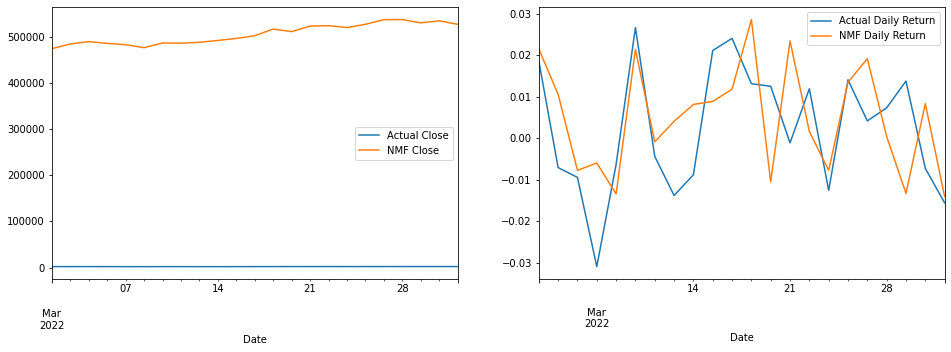

In [103]:
# <--
valY['NMF Close'] = valX.dot(list(weights.values()))
evaluate(valY,'NMF Close',is_test=False)

**Test Results**

Benchmark
******************************
Active Return: 0.08371
Tracking Error: 140  bps
Information Ratio: 5.98929
Price RMSE: 1036.5755351630814
Returns RMSE: 0.014688811647052866

Current Portfolio
******************************
Active Return: 0.01123
Tracking Error: 121  bps
Information Ratio: 0.92734
Price RMSE: 509838.71204517194
Returns RMSE: 0.012128538126892238


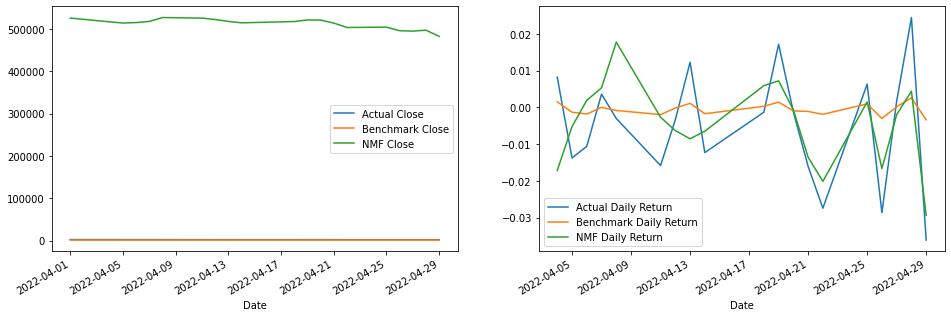

In [104]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['NMF Close'] = testX.dot(list(weights.values()))
evaluate(testY,'NMF Close',is_test=True)

The problem with this approach is that the prices cannot be properly replicated as we will not know the leverage factor in an unsupervised learning method, thus the price RMSE is very high.

# 8. Allocation with Particle Swarm Optimisation (PSO)

PSO emulates 'social creatures' that are scattered around the search space and moving to find the optima. Each particle represents a set of portfolio weights which are randomly initialized. Their movements are affected by (1) their individual desire to search and  (2) the collective action of the group or its neighbors.

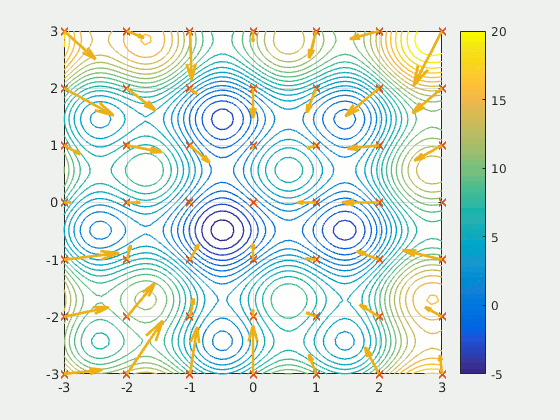

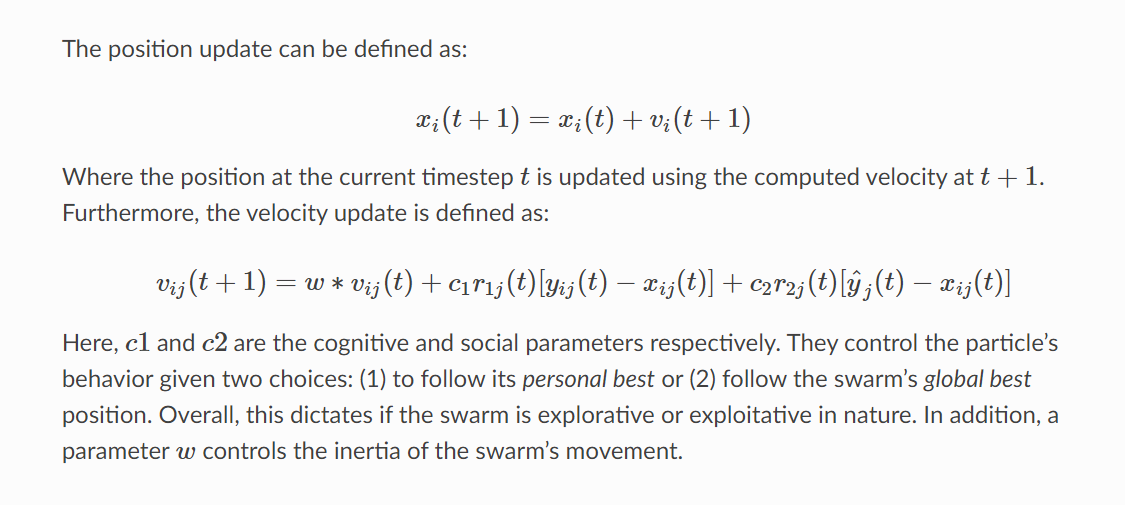

Grid search is performed over c1, c2, w

Bounds = [0,1] since coeffs are non-negative and the value of the component cannot be more than the index



In [105]:
# <--
# Train Val Test split
df = components21.copy()
df.dropna(inplace=True)
df['Actual Close'] = RUI['Actual Close']

train = df[df.index <= train_end]
val = df[(df.index >= val_start) & (df.index <= val_end)]
test = df[(df.index >= test_start) & (df.index <= test_end)]

trainX = train.drop('Actual Close', axis=1)
trainY = train['Actual Close']
valX = val.drop('Actual Close', axis=1)
valY = pd.DataFrame({'Actual Close':val['Actual Close']})
testX = test.drop('Actual Close', axis=1)
testY = pd.DataFrame({'Actual Close':test['Actual Close']})

**Grid Search**

In [106]:
def find_particle_loss(coeffs):
    trainX_returns = trainX.pct_change().dropna()
    trainY_returns = trainY.pct_change().dropna()
    benchmark_tracking_error = np.std(trainX.dot(coeffs) - trainY)
    return benchmark_tracking_error

def swarm(x):
    n_particles = x.shape[0]
    particle_loss = [find_particle_loss(x[i]) for i in range(n_particles)]
    return particle_loss

options = {'c1': [1.5,2.5],
           'c2': [1,2],
           'w': [0.4,0.5]}

feature_count = len(trainX.columns)
min_bound = feature_count*[0]
max_bound = feature_count*[1]

g = GridSearch(GlobalBestPSO,
               objective_func=swarm,
               n_particles=100,
               dimensions=len(trainX.columns),
               options=options,
               bounds=(min_bound,max_bound),
               iters=100)
# Perform optimization, cost=lowest particle_loss among all iterations
best_cost, best_pos = g.search()

2023-02-21 18:44:15,949 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.15e+3
2023-02-21 18:45:15,190 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1148.6379557972064, best pos: [0.78349778 0.44845199 0.05504444 0.30139288 0.47706234 0.05080936
 0.93844211 0.87639144 0.38687238 0.93954708]
2023-02-21 18:45:15,259 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=43.3
2023-02-21 18:46:28,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 43.32622697694738, best pos: [1.94804582e-01 8.64902786e-01 6.81628687e-04 4.07018151e-01
 7.56964568e-01 3.60456659e-01 8.92940612e-01 7.72055121e-01
 2.72267689e-01 9.49319095e-01]
2023-02-21 18:46:28,670 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'

**Model Evaluation**

In [107]:
optimizer = GlobalBestPSO(n_particles=1000,
               dimensions=len(trainX.columns),
               options=best_pos,
               bounds=(min_bound,max_bound))
# Perform optimization, cost=lowest particle_loss among all iterations
cost, pos = optimizer.optimize(swarm,iters=100)

2023-02-21 18:53:08,623 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=23 
2023-02-21 19:04:19,107 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.986891178532254, best pos: [6.80841472e-01 5.28121897e-01 5.30269338e-04 4.70416833e-01
 4.70338732e-01 7.08538070e-01 7.65970748e-01 6.87983775e-01
 7.46786721e-01 5.49519232e-01]


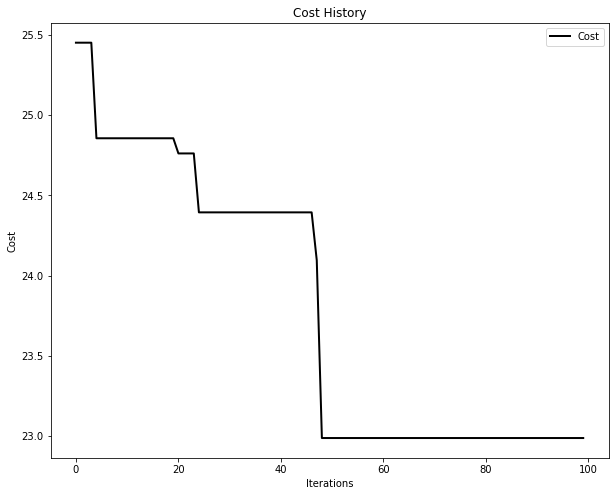

In [108]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

**Portfolio Allocation**


Portfolio Allocation:


,Component,Weight(%)
0,META,13.655986
1,TSLA,13.313966
2,JPM,12.632056
3,MSFT,12.265607
4,AAPL,12.138272
5,V,9.797015
6,AMZN,9.415536
7,GOOG,8.386750
8,JNJ,8.385358
9,BRK-A,0.009454



Portfolio Simulated Close = 
5.60905(0.12138*AAPL + 0.09416*AMZN + 9e-05*BRK-A + 0.08387*GOOG + 0.08385*JNJ + 0.12632*JPM + 0.13656*META + 0.12266*MSFT + 0.13314*TSLA + 0.09797*V)


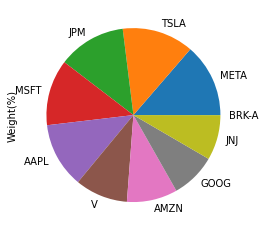

In [109]:
# <--
leverage_factor = sum(pos)
weights = pos/leverage_factor
weights = dict(zip(list(trainX.columns), list(weights)))

s1 = str(round(leverage_factor,5))+"("
for component,weight in weights.items():
    s1 += str(round(weight,5))+'*'+component+" + "
s1 = s1[:-3]+")"

print("\nPortfolio Allocation:")
allocation = pd.DataFrame({'Component':trainX.columns, 'Weight(%)':np.multiply(list(weights.values()),100)}).sort_values('Weight(%)',ascending=False)
allocation.set_index('Component',inplace=True)
allocation.plot.pie(y='Weight(%)',legend=None)
allocation.reset_index(inplace=True)
display(allocation)

print('\nPortfolio Simulated Close = ')
print(s1)


**Validation Results**


Current Portfolio
******************************
Active Return: 0.05008
Tracking Error: 55  bps
Information Ratio: 9.17792
Price RMSE: 1023.0892798882624
Returns RMSE: 0.005875708243581014


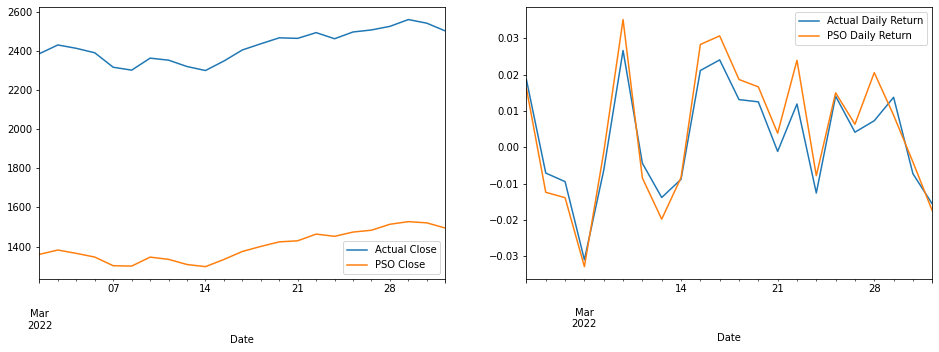

In [112]:
valY['PSO Close'] = leverage_factor*valX.dot(list(weights.values()))
evaluate(valY,'PSO Close',is_test=False)

**Test Results**

Benchmark
******************************
Active Return: 0.08371
Tracking Error: 140  bps
Information Ratio: 5.98929
Price RMSE: 1036.5755351630814
Returns RMSE: 0.014688811647052866

Current Portfolio
******************************
Active Return: -0.02459
Tracking Error: 80  bps
Information Ratio: -3.08209
Price RMSE: 1001.552723130177
Returns RMSE: 0.008094442045323771


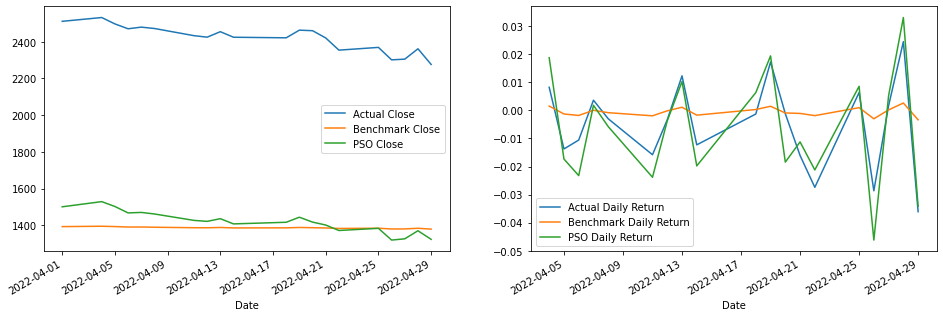

In [113]:
# <--
testY['Benchmark Close'] = benchmark['Benchmark Close']
testY['PSO Close'] = leverage_factor*testX.dot(list(weights.values()))
evaluate(testY,'PSO Close',is_test=True)

NMF (Tracking Error: 56 bps, Price RMSE: 368.7, Returns RMSE: 0.006032)

NNLS (Tracking Error: 43 bps, Price RMSE: 27.37, Returns RMSE: 0.004587)

Tracking Error for the PSO model is the lowest